In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip /content/face-expression-recognition-dataset.zip

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import keras
import tensorflow as tf

In [11]:
# Training Data Filepath
train_data = Path('/content/images/train')
train_data_list = list(train_data.glob(r'**/*.jpg'))
train_class_list = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], train_data_list))

# Testing Data Filepath
test_data_path = Path('/content/images/validation')
test_filepath_list = list(test_data_path.glob(r'**/*.jpg'))
test_class_list = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], test_filepath_list))

In [12]:
final_df = pd.DataFrame(columns = ['filepath', 'class', 'type'])

train_df = [{'filepath': str(filepath), 'class': class_, 'type': 'train'} for filepath, class_, in zip(train_data_list, train_class_list)]
test_df = [{'filepath': str(filepath), 'class': class_, 'type': 'test'} for filepath, class_, in zip(test_filepath_list, test_class_list)]

final_df = pd.concat([final_df, pd.DataFrame(train_df),pd.DataFrame(test_df)])

In [4]:
final_df.head()

,filepath,class,type


In [5]:
final_df['type'].value_counts()

Series([], Name: count, dtype: int64)

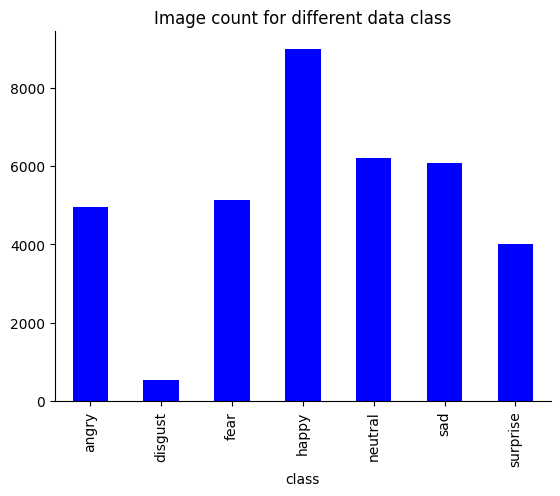

In [13]:
final_df.groupby('class').size().plot(kind='bar', color='blue')
plt.title('Image count for different data class')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
final_df[['class', 'type']].value_counts()

class     type 
happy     train    7164
neutral   train    4982
sad       train    4938
fear      train    4103
angry     train    3993
surprise  train    3205
happy     test     1825
neutral   test     1216
sad       test     1139
fear      test     1018
angry     test      960
surprise  test      797
disgust   train     436
          test      111
Name: count, dtype: int64

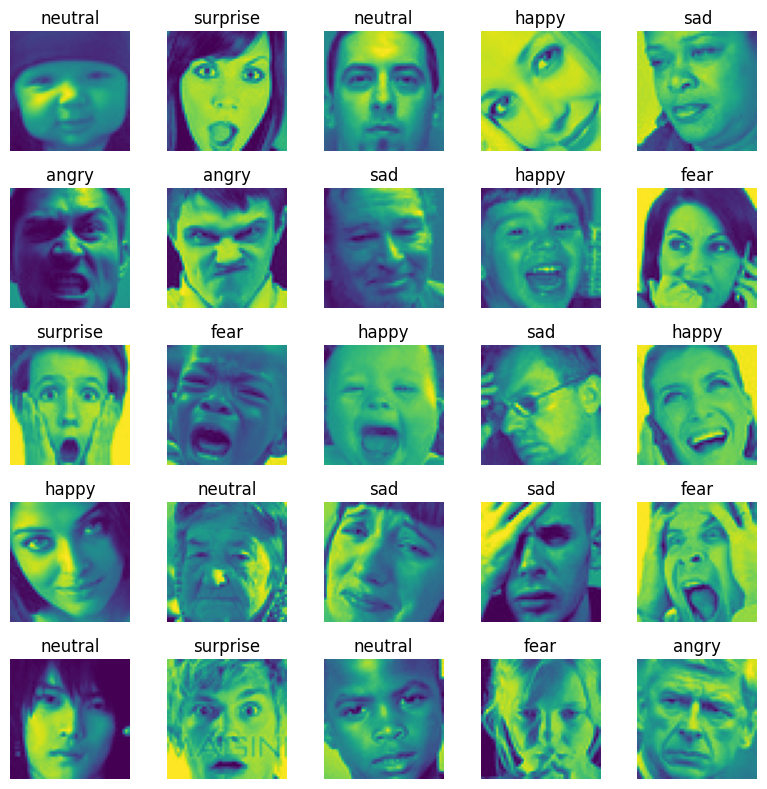

In [15]:
sample_df = final_df.sample(5 * 5, random_state=42)

# Create the figure and axes
fig, axes = plt.subplots(5, 5, figsize=(8, 8))

# Iterate over the axes and plot the images
for ax, img_path, title in zip(axes.flat, sample_df['filepath'], sample_df['class']):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

# Show the figure
fig.tight_layout()
plt.show()

In [16]:
train_gen_instance = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./255,
                             width_shift_range=0.2 ,
                             height_shift_range=0.2 ,
                             validation_split = 0.2,
                             zoom_range=0.2)
test_gen_instance = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [17]:
train_df = final_df[final_df['type']== 'train'].drop('type', axis = 1)
train_images = train_gen_instance.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'filepath',
                                           y_col = 'class',
                                           target_size = (48,48),
                                           batch_size = 128,
                                          subset = 'training',
                                          color_mode="grayscale",
                                          class_mode='categorical')

valid_images = train_gen_instance.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'filepath',
                                           y_col = 'class',
                                           target_size = (48,48),
                                           batch_size = 128,
                                           subset = 'validation',
                                          color_mode="grayscale",
                                          class_mode='categorical')


test_df = final_df[final_df['type']== 'test'].drop('type', axis = 1)
test_images = test_gen_instance.flow_from_dataframe(dataframe = test_df,
                                           x_col = 'filepath',
                                           y_col = 'class',
                                           target_size = (48,48),
                                           batch_size = 128,
                                          color_mode="grayscale",
                                          class_mode='categorical')

Found 23057 validated image filenames belonging to 7 classes.
Found 5764 validated image filenames belonging to 7 classes.
Found 7066 validated image filenames belonging to 7 classes.


In [18]:
def plot_training_results(history, title):
    plt.figure(figsize=(9.5, 3))
    plt.subplot(1,2,1)
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.plot(history.history['loss'], label='Training Loss', color = 'red')
    plt.title(title + ' Loss')


    plt.subplot(1,2,2)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color = 'green')
    plt.title(title + ' Accuracy')
    plt.show()


In [28]:
# Initialising the CNN
cnn_model = keras.Sequential()

# 1 - Convolution
cnn_model.add(keras.layers.Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# 2nd Convolution layer
cnn_model.add(keras.layers.Conv2D(128,(5,5), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# 3rd Convolution layer
cnn_model.add(keras.layers.Conv2D(512,(3,3), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# 4th Convolution layer
cnn_model.add(keras.layers.Conv2D(512,(3,3), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# Flattening
cnn_model.add(keras.layers.Flatten())

# Fully connected layer 1st layer
cnn_model.add(keras.layers.Dense(256))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.Dropout(0.25))

# Fully connected layer 2nd layer
cnn_model.add(keras.layers.Dense(512))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.Dropout(0.25))

cnn_model.add(keras.layers.Dense(7, activation='softmax'))

cnn_model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_history = cnn_model.fit(train_images,
                            steps_per_epoch=train_images.n//train_images.batch_size,
                            epochs=20,
                            validation_data = valid_images,
                            validation_steps = valid_images.n//valid_images.batch_size,
                            )

Epoch 1/20
180/180 [==============================] - 31s 136ms/step - loss: 1.7790 - accuracy: 0.2734 - val_loss: 4.7346 - val_accuracy: 0.0000e+00
Epoch 2/20
180/180 [==============================] - 23s 128ms/step - loss: 1.6598 - accuracy: 0.2981 - val_loss: 5.9140 - val_accuracy: 0.0000e+00
Epoch 3/20
180/180 [==============================] - 23s 126ms/step - loss: 1.6144 - accuracy: 0.3264 - val_loss: 5.9548 - val_accuracy: 0.0000e+00
Epoch 4/20
180/180 [==============================] - 23s 128ms/step - loss: 1.5383 - accuracy: 0.3741 - val_loss: 6.5584 - val_accuracy: 0.0000e+00
Epoch 5/20
180/180 [==============================] - 23s 127ms/step - loss: 1.4393 - accuracy: 0.4271 - val_loss: 6.9670 - val_accuracy: 0.0106
Epoch 6/20
180/180 [==============================] - 23s 126ms/step - loss: 1.3620 - accuracy: 0.4621 - val_loss: 7.4971 - val_accuracy: 0.0010
Epoch 7/20
180/180 [==============================] - 23s 129ms/step - loss: 1.2917 - accuracy: 0.4937 - val_loss:

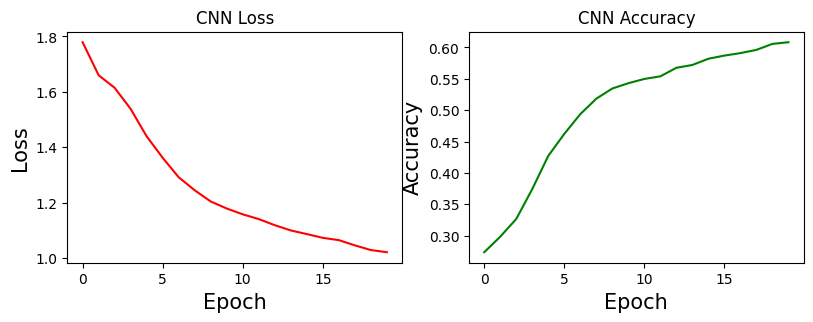

In [30]:
plot_training_results(cnn_history, 'CNN')

46/46 [==============================] - 4s 88ms/step


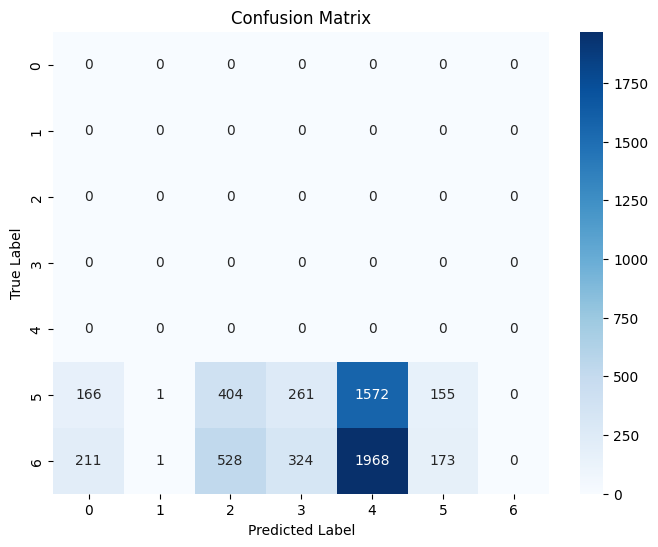

In [31]:
# Making predictions on validation set
valid_pred = cnn_model.predict(valid_images)
valid_pred_labels = np.argmax(valid_pred, axis=1)
true_labels = valid_images.labels

# Computing confusion matrix
conf_matrix = confusion_matrix(true_labels, valid_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
lstm_model = keras.Sequential()

lstm_model.add(keras.layers.Conv2D(64, (3,3), padding="same",
                                  input_shape=(48,48, 1)))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(keras.layers.Conv2D(128, (5,5), padding="same"))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(keras.layers.Conv2D(512, (3,3), padding="same"))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(keras.layers.Conv2D(512, (3,3), padding="same"))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(tf.keras.layers.Reshape((9, 512)))
lstm_model.add(tf.keras.layers.LSTM(64))


lstm_model.add(keras.layers.Dense(7, activation='softmax'))

lstm_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

lstm_history = lstm_model.fit(train_images,
                            steps_per_epoch=train_images.n//train_images.batch_size,
                            epochs=20,
                            validation_data = valid_images,
                            validation_steps = valid_images.n//valid_images.batch_size,
                            )

Epoch 1/20
180/180 [==============================] - 27s 129ms/step - loss: 1.6109 - accuracy: 0.3134 - val_loss: 4.5924 - val_accuracy: 0.0000e+00
Epoch 2/20
180/180 [==============================] - 23s 126ms/step - loss: 1.5464 - accuracy: 0.3584 - val_loss: 4.9019 - val_accuracy: 0.0000e+00
Epoch 3/20
180/180 [==============================] - 23s 125ms/step - loss: 1.4338 - accuracy: 0.4263 - val_loss: 4.8237 - val_accuracy: 0.0000e+00
Epoch 4/20
180/180 [==============================] - 23s 127ms/step - loss: 1.3731 - accuracy: 0.4507 - val_loss: 5.1257 - val_accuracy: 0.0052
Epoch 5/20
180/180 [==============================] - 23s 125ms/step - loss: 1.3174 - accuracy: 0.4783 - val_loss: 5.3796 - val_accuracy: 0.0019
Epoch 6/20
180/180 [==============================] - 23s 125ms/step - loss: 1.2669 - accuracy: 0.5030 - val_loss: 5.2451 - val_accuracy: 0.0028
Epoch 7/20
180/180 [==============================] - 23s 127ms/step - loss: 1.2442 - accuracy: 0.5140 - val_loss: 5.5

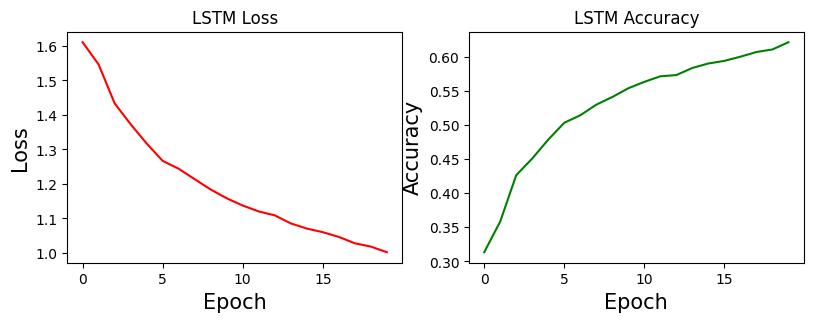

In [32]:
plot_training_results(lstm_history, 'LSTM')

46/46 [==============================] - 4s 87ms/step


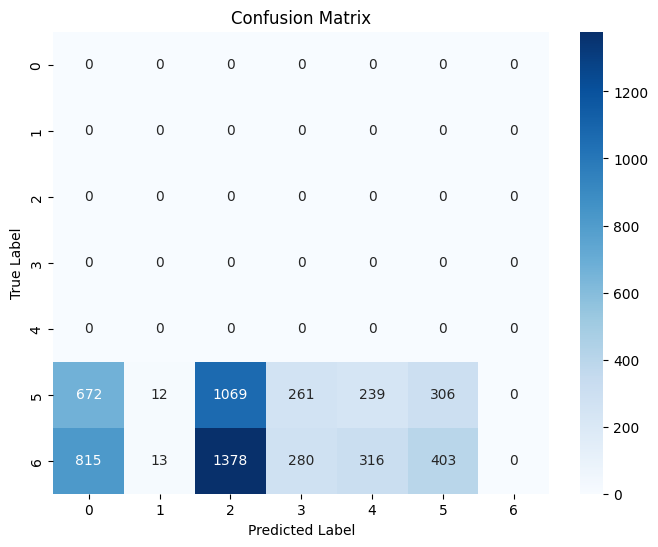

In [33]:
# Making predictions on validation set
valid_pred = lstm_model.predict(valid_images)
valid_pred_labels = np.argmax(valid_pred, axis=1)
true_labels = valid_images.labels

# Computing confusion matrix
conf_matrix = confusion_matrix(true_labels, valid_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [34]:
dnn_model = keras.Sequential()

dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.25))

dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.27))

dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.3))

dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.27))

dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.25))

dnn_model.add(keras.layers.Flatten())


dnn_model.add(keras.layers.Dense(7, activation='softmax'))


dnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

dnn_history = dnn_model.fit(train_images,
                            steps_per_epoch=train_images.n//train_images.batch_size,
                            epochs=20,
                            validation_data = valid_images,
                            validation_steps = valid_images.n//valid_images.batch_size,
                            )

Epoch 1/20
180/180 [==============================] - 53s 274ms/step - loss: 12.5856 - accuracy: 0.2275 - val_loss: 19.2251 - val_accuracy: 0.0012
Epoch 2/20
180/180 [==============================] - 46s 255ms/step - loss: 16.5987 - accuracy: 0.2269 - val_loss: 28.5865 - val_accuracy: 0.0047
Epoch 3/20
180/180 [==============================] - 48s 264ms/step - loss: 15.5824 - accuracy: 0.2281 - val_loss: 57.6594 - val_accuracy: 0.0000e+00
Epoch 4/20
180/180 [==============================] - 48s 264ms/step - loss: 13.1967 - accuracy: 0.2306 - val_loss: 25.7976 - val_accuracy: 0.0464
Epoch 5/20
180/180 [==============================] - 47s 263ms/step - loss: 10.0553 - accuracy: 0.2291 - val_loss: 24.0770 - val_accuracy: 0.0017
Epoch 6/20
180/180 [==============================] - 48s 265ms/step - loss: 6.9156 - accuracy: 0.2335 - val_loss: 12.3892 - val_accuracy: 0.0233
Epoch 7/20
180/180 [==============================] - 48s 264ms/step - loss: 3.9513 - accuracy: 0.2345 - val_loss: 

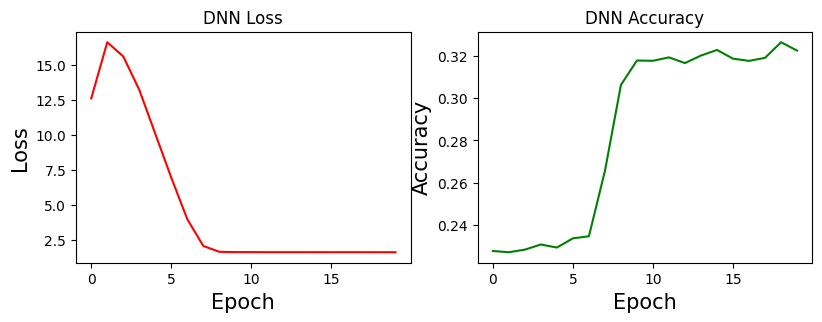

In [35]:
plot_training_results(dnn_history, 'DNN')

46/46 [==============================] - 5s 104ms/step


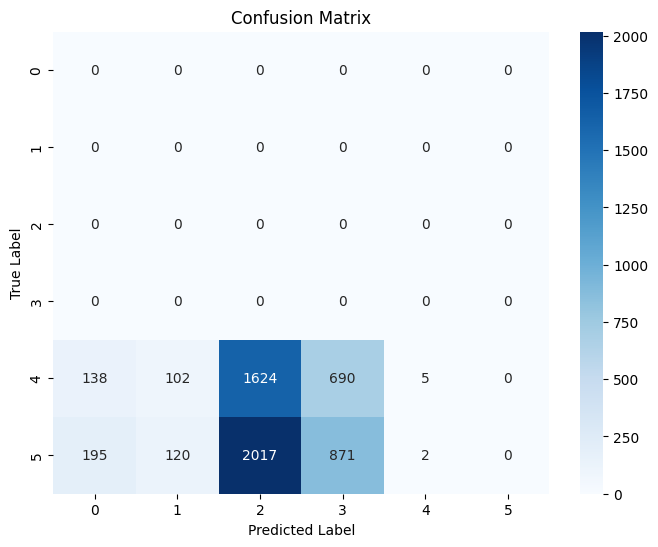

In [36]:
# Making predictions on validation set
valid_pred = dnn_model.predict(valid_images)
valid_pred_labels = np.argmax(valid_pred, axis=1)
true_labels = valid_images.labels

# Computing confusion matrix
conf_matrix = confusion_matrix(true_labels, valid_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

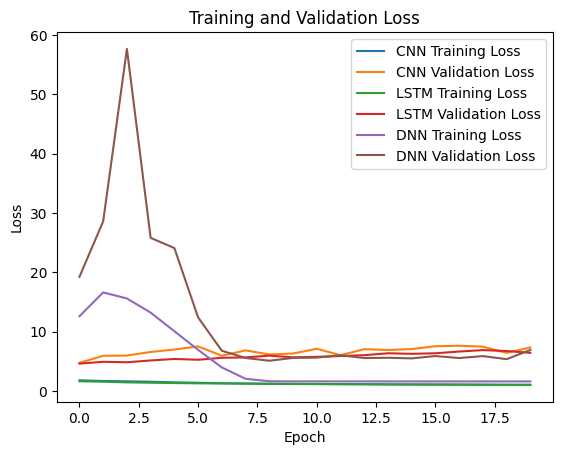

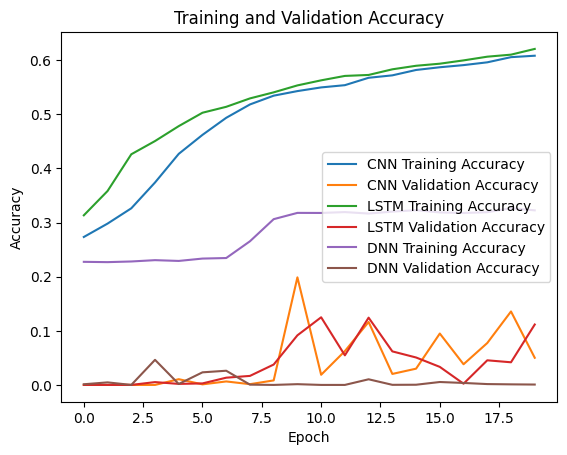

In [37]:
# Plotting loss for all models
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(dnn_history.history['loss'], label='DNN Training Loss')
plt.plot(dnn_history.history['val_loss'], label='DNN Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy for all models
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(dnn_history.history['accuracy'], label='DNN Training Accuracy')
plt.plot(dnn_history.history['val_accuracy'], label='DNN Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()